In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from tqdm.auto import tqdm
import os


sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Germany', 'Austria',
       'France', 'Slovakia', 'Belgium', 'Italy', 'Portugal',
       'Netherlands']
traces,traces_without_soccer,traces_primary_soccer, models, dls = [], [], [], [],[]
for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)
    
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")

    traces_without_soccer.append(trace_without_soccer)
    traces_primary_soccer.append(trace_primary_soccer)
trace_overall = load("/data.nst/smohr/covid19_soccer_data/trace_overall_effekt.pkl")

  0%|          | 0/12 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia
Use 4000 sample runs for Scotland
Use 4000 sample runs for Spain
Use 4000 sample runs for Germany
Use 4000 sample runs for Austria
Use 4000 sample runs for France
Use 4000 sample runs for Slovakia
Use 4000 sample runs for Belgium
Use 4000 sample runs for Italy
Use 4000 sample runs for Portugal
Use 4000 sample runs for Netherlands


In [3]:
infections_no = []
infections_primary = []
infections_subsequent = []
for i, country in enumerate(countries):
    shape = traces_without_soccer[i].predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = traces_without_soccer[i].predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4])
    y1 = traces_primary_soccer[i].predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y0
    y2 = traces[i].posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - models[i].sim_begin).days
    i_end = (end - models[i].sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_subsequent.append(y2)
    
data_primary  = pd.DataFrame()
means = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_subsequent[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    means.append(np.mean(temp["percentage_primary"]))
country_order_primar = np.argsort(means)[::-1]

data_primary_and_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_subsequent[i])/(infections_no[i] + infections_primary[i] + infections_subsequent[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    means.append(np.mean(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(means)[::-1]


# Compute interesting values as fraction, as incidence and as cases
primary_frac = []
for i, country in enumerate(countries):
    temp = data_primary[data_primary["country"] == country].drop(columns=["country","gender"])
    primary_frac.append(temp.to_numpy()[:,0])

primary_and_subsequent_frac = []
for i, country in enumerate(countries):
    temp = data_primary_and_subsequent[data_primary_and_subsequent["country"] == country].drop(columns=["country","gender"])
    primary_and_subsequent_frac.append(temp.to_numpy()[:,0])

primary_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_inci.append(temp / dls[i].population[0]*1e6)

primary_and_subsequent_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_subsequent[i]
    primary_and_subsequent_inci.append(temp/ dls[i].population[0]*1e6)

primary_cases = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_cases.append(temp)

primary_and_subsequent_cases = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_subsequent[i]
    primary_and_subsequent_cases.append(temp)
    

In [4]:
def get_xy(trace,trace_without_soccer,trace_primary_soccer):
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(model.sim_begin, model.sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0)
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y0
    y2 = trace.posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y1 - y0
    
    y = [
        y0[:,0]+y0[:,1],
        y1[:,0]+y1[:,1],
        y2[:,0]+y2[:,1]
    ]
    return x, y

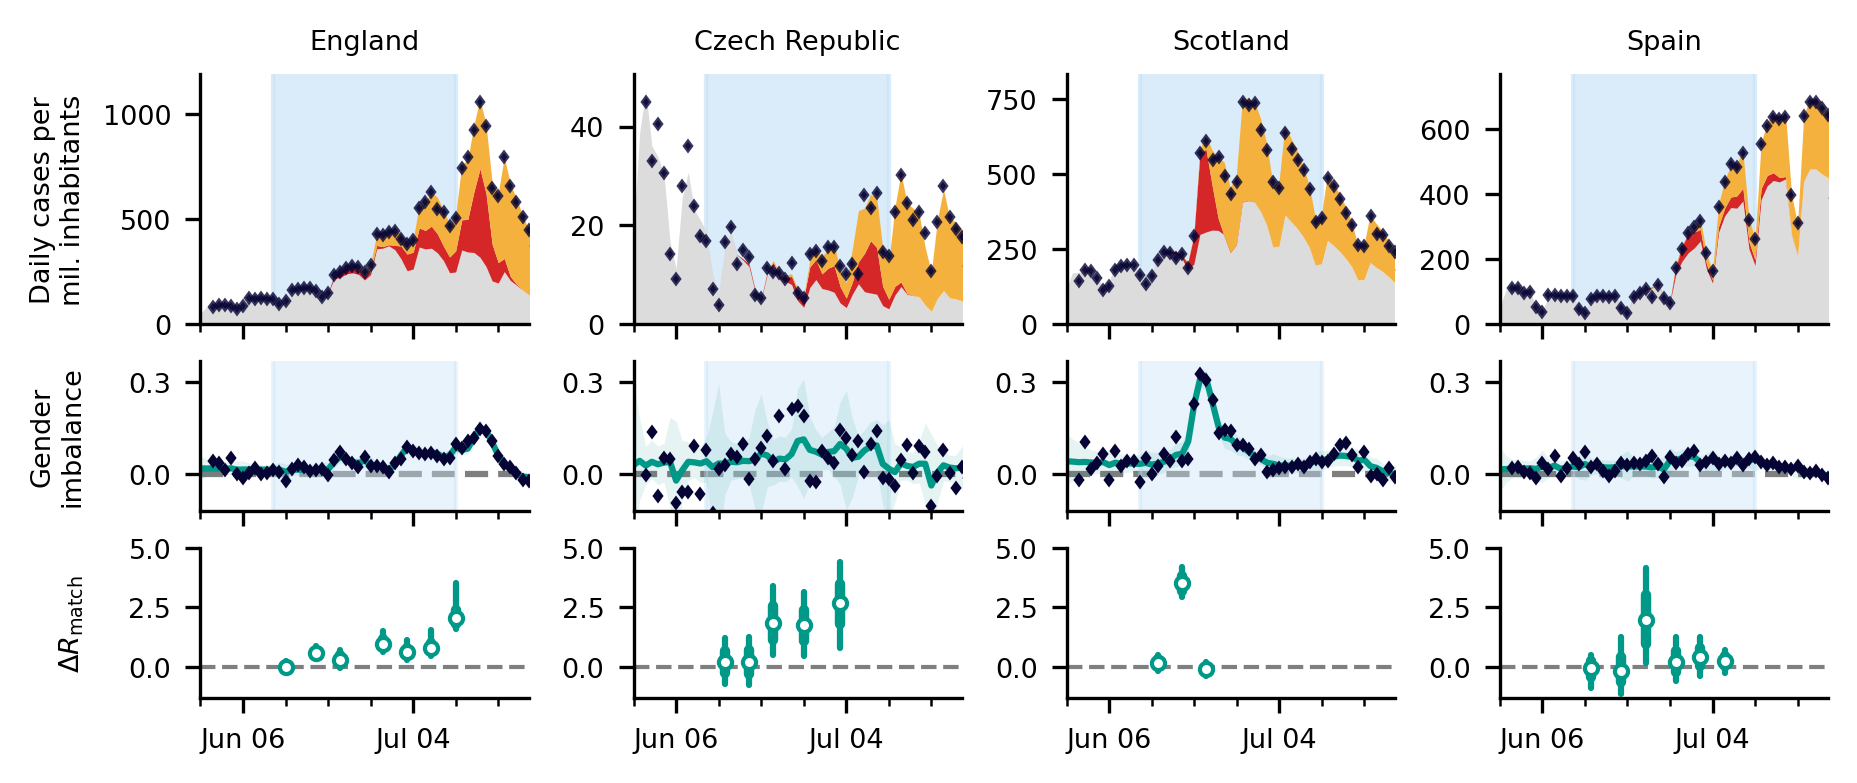

In [28]:
from covid19_soccer.plot.timeseries import _uefa_range, incidence, stacked_filled, fraction_male_female
from covid19_soccer.plot.other import game_effects
from covid19_soccer.plot.other import format_date_axis

colors_base = ["gainsboro","tab:red","#f5b13d"]
xlim_ts = [ # Plotting x lims
    datetime.datetime(2021,5,30),
    datetime.datetime(2021,7,23)
] 
gridspec = { # Layout
    "wspace": 0.32,
    "height_ratios": [3,1.8,1.8]
}
fig,axes = plt.subplots(3,4,figsize=(7,2.7),gridspec_kw=gridspec)

# First row
for i, ax in zip([0,1,2,3],axes[0]):
    # Show time of uefa championship
    x , y = get_xy(traces[i],traces_without_soccer[i],traces_primary_soccer[i])
    for j in range(len(y)):
        y[j] = y[j]/dls[i].population[0]*1e6
    
    _uefa_range(ax)
    incidence(ax, traces[i], models[i], dls[i],lw=0.5,color="none")
    stacked_filled(
        x,
        [yi/2 for yi in y],
        ax=ax,
        colors=colors_base,
        label="b",
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    if countries[i] == "Czechia":
        ax.set_title("Czech Republic")
    else:
        ax.set_title(countries[i])
    ax.set_xlim(*xlim_ts)
    if i == 0:
        ax.set_ylabel("Daily cases per\nmil. inhabitants")
        
# Second row
for i,ax in zip([0,1,2,3],axes[1]):
    fraction_male_female(ax,traces[i],models[i],dls[i])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_xlim(*xlim_ts)
    ax.set_ylim(-0.12,0.37)
    ax.set_yticks([0,0.3])
    if i == 0:
        ax.set_ylabel("Gender\nimbalance")

    
# Third row
for i,ax in zip([0,1,2,3],axes[2]):
    game_effects(ax,traces[i],models[i],dls[i],type="bars")
    ax.set_xlim(*xlim_ts)
    ax.set_ylim(-1.3,5)
    ax.set_yticks([0,2.5,5])
    ax.set_ylabel("")
    if i == 0:
        ax.set_ylabel("$\Delta R_\mathrm{match}$")
        
fig.align_ylabels()
fig.savefig(f"../figures/primary_and_subsequent/overview_1.pdf", **save_kwargs)
fig.savefig(f"../figures/primary_and_subsequent/overview_1.png", **save_kwargs)
plt.show()

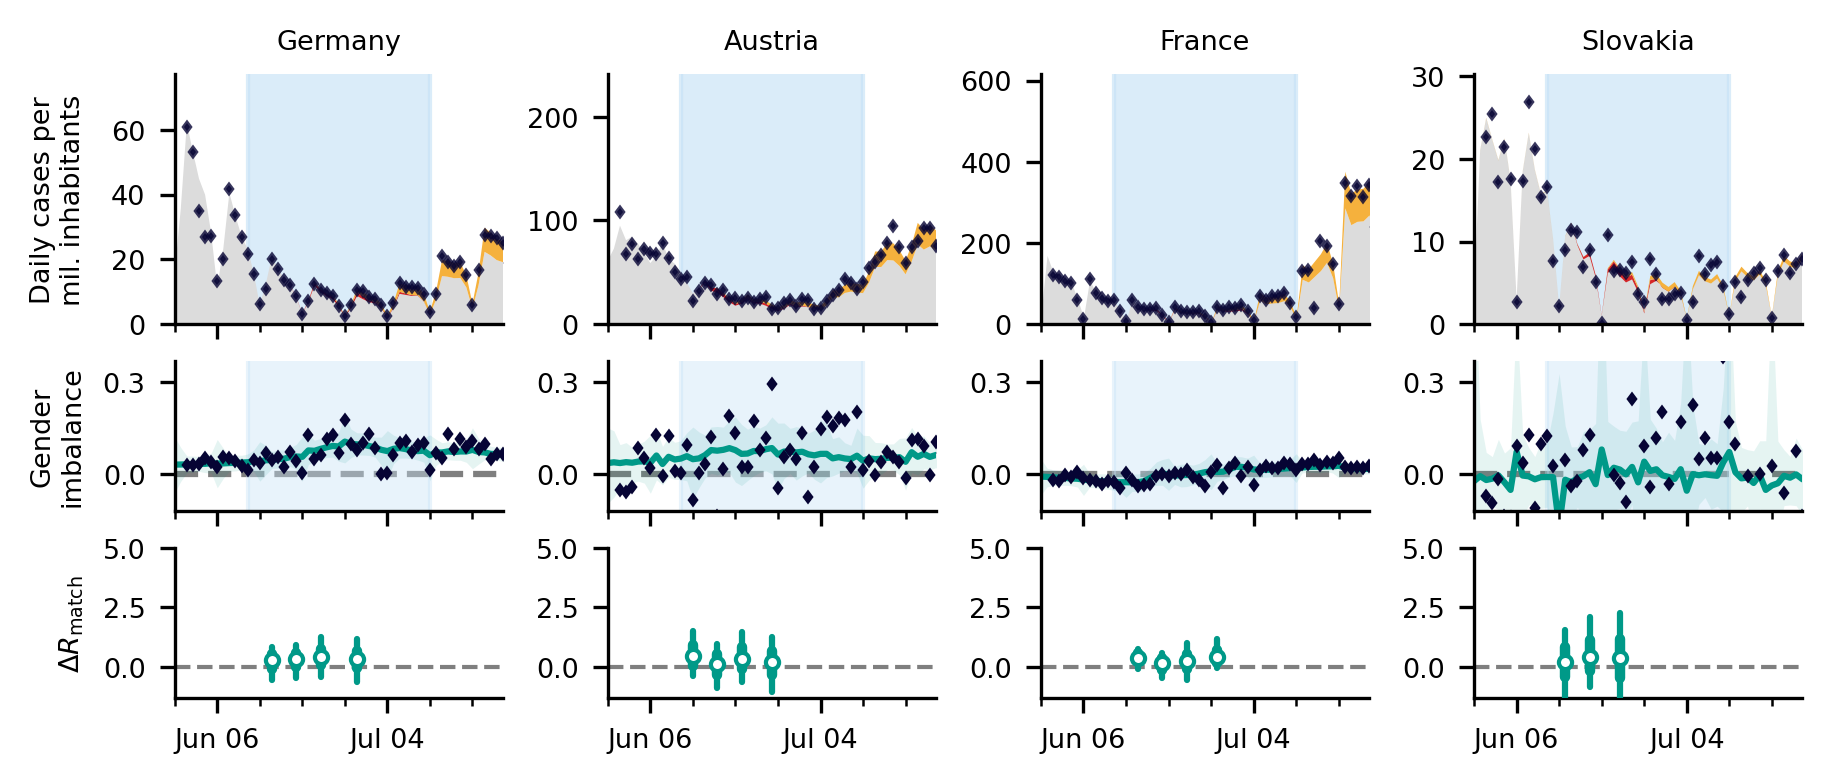

In [29]:
fig,axes = plt.subplots(3,4,figsize=(7,2.7),gridspec_kw=gridspec)

# First row
for i, ax in zip([4,5,6,7],axes[0]):
    # Show time of uefa championship
    x , y = get_xy(traces[i],traces_without_soccer[i],traces_primary_soccer[i])
    for j in range(len(y)):
        y[j] = y[j]/dls[i].population[0]*1e6
    
    _uefa_range(ax)
    incidence(ax, traces[i], models[i], dls[i],lw=0.5,color="none")
    stacked_filled(
        x,
        [yi/2 for yi in y],
        ax=ax,
        colors=colors_base,
        label="b",
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_title(countries[i])
    ax.set_xlim(*xlim_ts)
    if i % 4 == 0:
        ax.set_ylabel("Daily cases per\nmil. inhabitants")
        
# Second row
for i,ax in zip([4,5,6,7],axes[1]):
    fraction_male_female(ax,traces[i],models[i],dls[i])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_xlim(*xlim_ts)
    ax.set_ylim(-0.12,0.37)
    ax.set_yticks([0,0.3])
    if i % 4 == 0:
        ax.set_ylabel("Gender\nimbalance")

# Third row
for i,ax in zip([4,5,6,7],axes[2]):
    game_effects(ax,traces[i],models[i],dls[i],type="bars")
    ax.set_xlim(*xlim_ts)
    ax.set_ylabel("")
    ax.set_ylim(-1.3,5)
    ax.set_yticks([0,2.5,5])
    if i % 4 == 0:
        ax.set_ylabel("$\Delta R_\mathrm{match}$")
        
fig.align_ylabels()
fig.savefig(f"../figures/primary_and_subsequent/overview_2.pdf", **save_kwargs)
fig.savefig(f"../figures/primary_and_subsequent/overview_2.png", **save_kwargs)
plt.show()

/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/timeseries.py:155: RuntimeWarning: invalid value encountered in true_divide
  y=(
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/timeseries.py:180: RuntimeWarning: invalid value encountered in true_divide
  imbalance = (


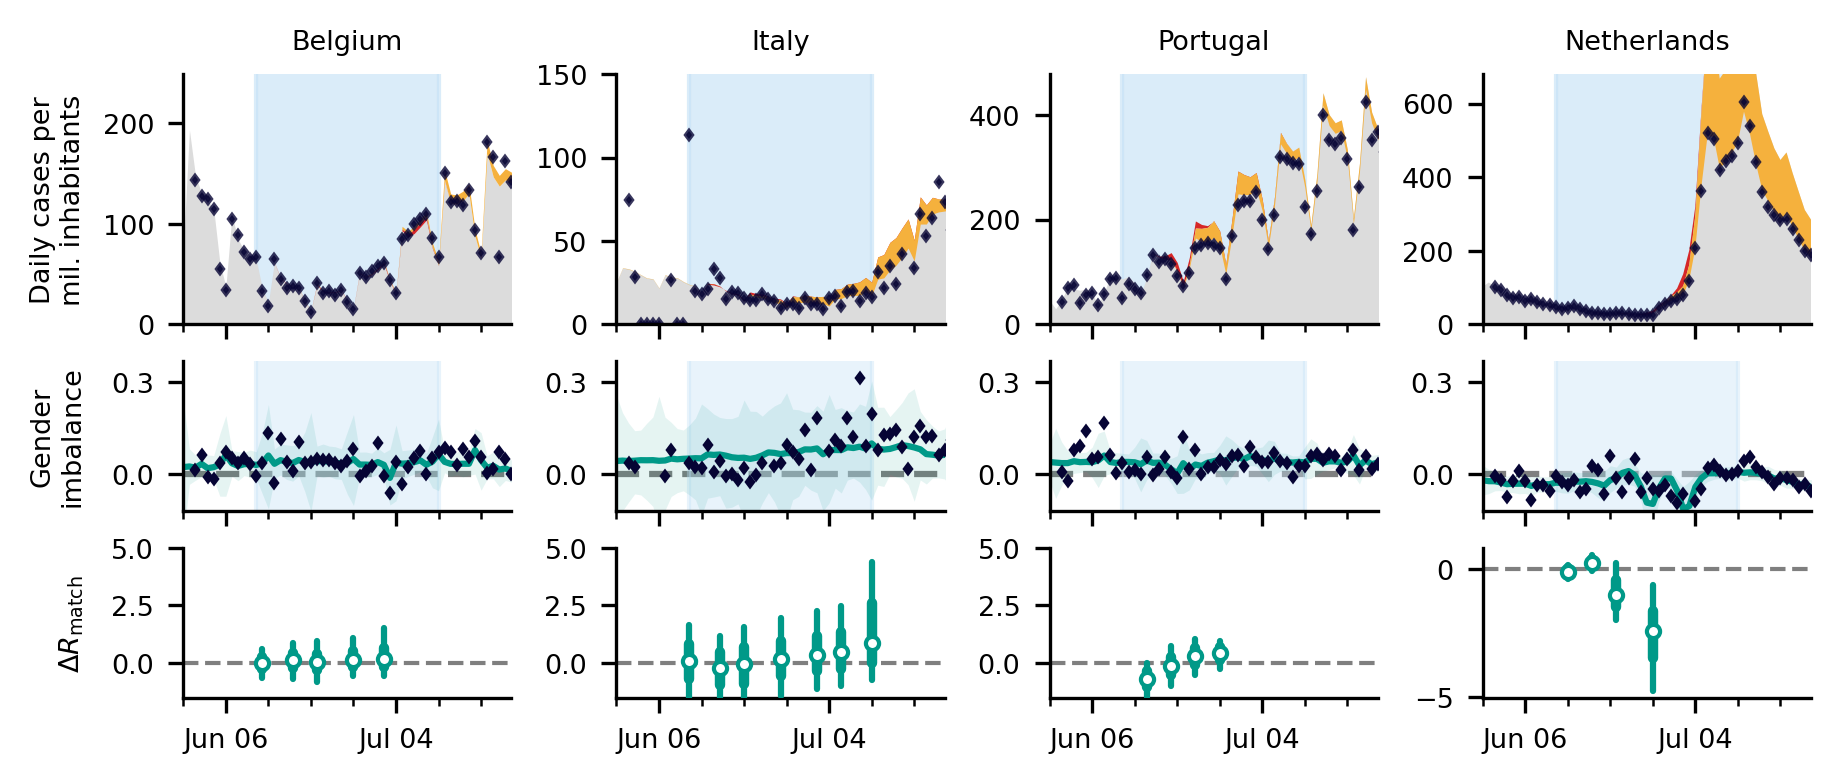

In [30]:
fig,axes = plt.subplots(3,4,figsize=(7,2.7),gridspec_kw=gridspec)

# First row
for i, ax in zip([8,9,10,11],axes[0]):
    # Show time of uefa championship
    x , y = get_xy(traces[i],traces_without_soccer[i],traces_primary_soccer[i])
    for j in range(len(y)):
        y[j] = y[j]/dls[i].population[0]*1e6
    _uefa_range(ax)
    incidence(ax, traces[i], models[i], dls[i],lw=0.5,color="none")
    stacked_filled(
        x,
        [yi/2 for yi in y],
        ax=ax,
        colors=colors_base,
        label="b",
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_title(countries[i])
    ax.set_xlim(*xlim_ts)
    if i % 4 == 0:
        ax.set_ylabel("Daily cases per\nmil. inhabitants")
    if i == 9:
        ax.set_ylim(0,150)
        
# Second row
for i,ax in zip([8,9,10,11],axes[1]):
    fraction_male_female(ax,traces[i],models[i],dls[i])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_xlim(*xlim_ts)
    if i % 4 == 0:
        ax.set_ylabel("Gender\nimbalance")
    ax.set_ylim(-0.12,0.37)
    ax.set_yticks([0,0.3])
    
# Third row
for i,ax in zip([8,9,10,11],axes[2]):
    game_effects(ax,traces[i],models[i],dls[i],type="bars")
    ax.set_xlim(*xlim_ts)
    ax.set_ylabel("")
    if i % 4 == 0:
        ax.set_ylabel("$\Delta R_\mathrm{match}$")
    if i != 11:
        ax.set_ylim(-1.5,5)
        ax.set_yticks([0,2.5,5])
        
fig.align_ylabels()
fig.savefig(f"../figures/primary_and_subsequent/overview_3.pdf", **save_kwargs)
fig.savefig(f"../figures/primary_and_subsequent/overview_3.png", **save_kwargs)
plt.show()

WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


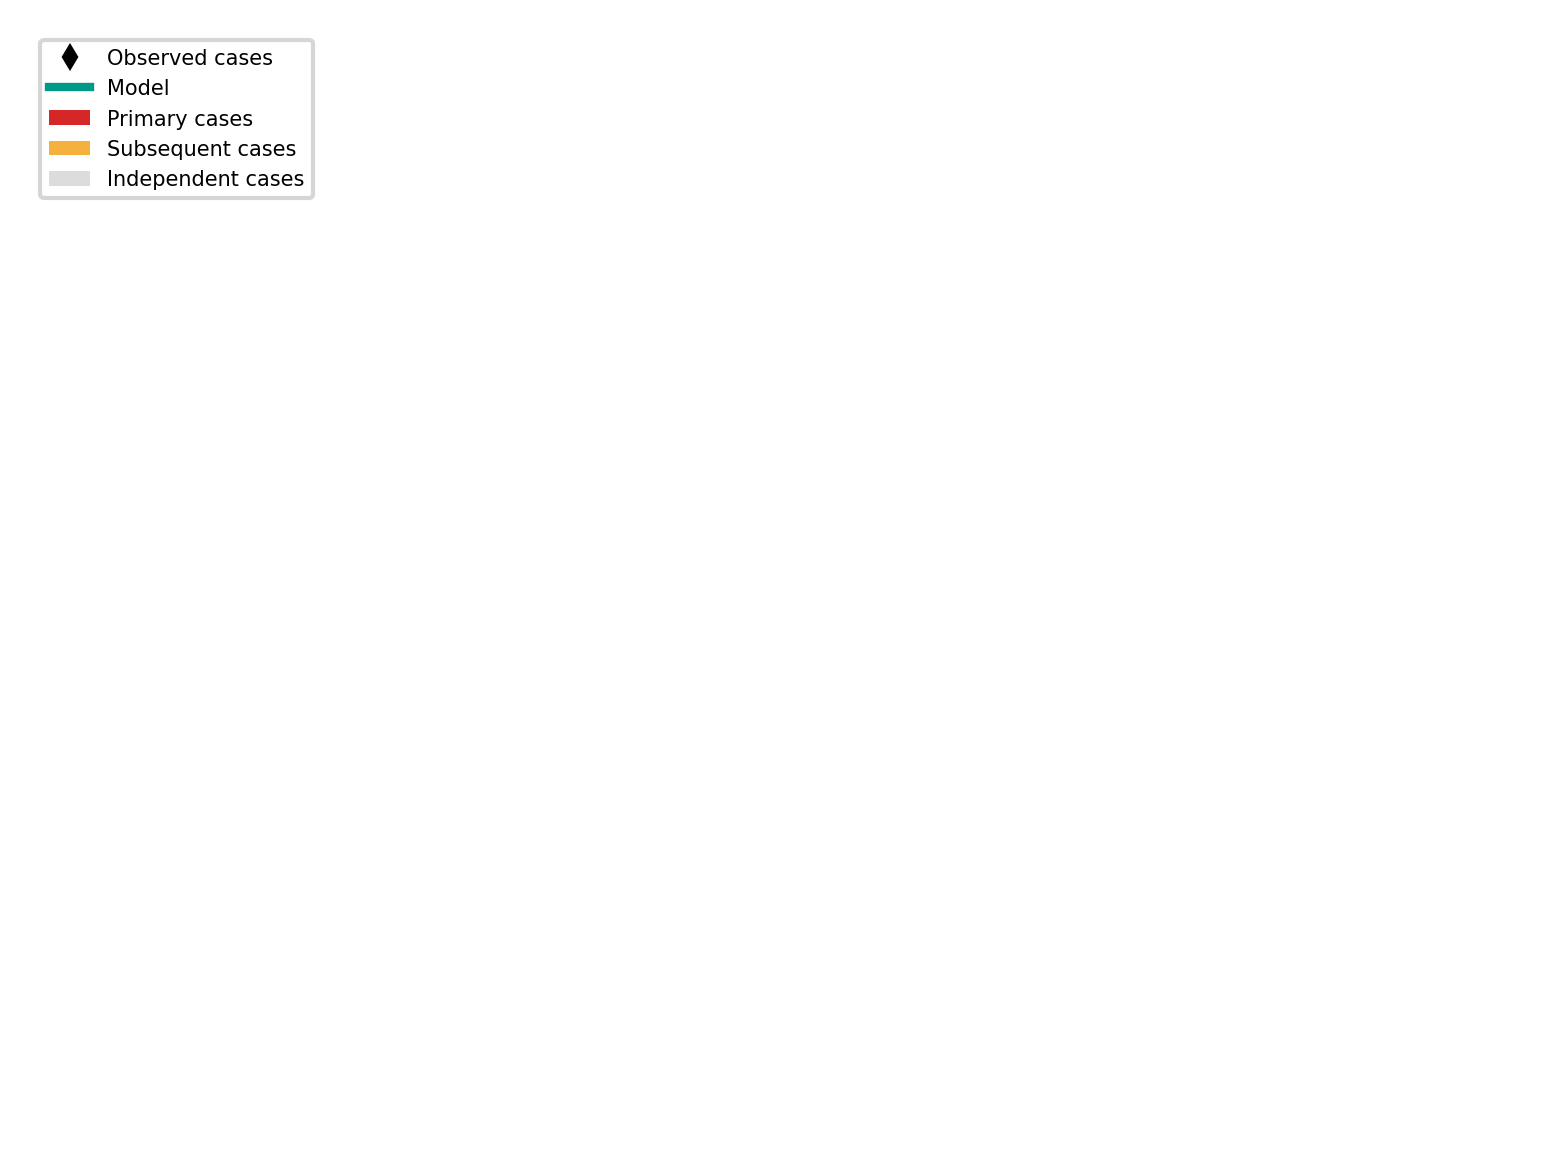

In [24]:
# Create legend
from covid19_soccer.plot.other import MulticolorPatch, MulticolorPatchHandler, Line2D, Rectangle, HandlerRect, rcParams

def plot_legend(ax,loc="upper left"):
    """ Plot the legend onto an axis
    Parameters
    ----------
    ax: mpl axis
    loc: strin
        Location of the legend
    """
    # Legend
    handles = []
    labels = []
    handles.append(Line2D(
                [0],
                [0],
                color="black",
                ls="none",
                lw=0,
                marker="d",
                ms=3.5
            ))
    labels.append("Observed cases") 
    
    handles.append(
        Line2D(
            [0],
            [0],
            color=rcParams.color_model,
            lw=2,
        )
    )
    labels.append("Model")

    handles.append(MulticolorPatch([colors_base[1]]))
    labels.append("Primary cases")
    
    handles.append(MulticolorPatch([colors_base[2]]))
    labels.append("Subsequent cases")
    
    handles.append(MulticolorPatch([colors_base[0]]))
    labels.append("Independent cases")

    #handles.append(Rectangle([0,0],width=1, height=2.2, lw=1, edgecolor=rcParams.color_championship_range,hatch="////",facecolor = 'none'))
    #labels.append("Time window of\nthe championship") 

    ax.legend(
        handles,
        labels,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), Rectangle: HandlerRect(),},
        loc=loc,
    )
    return ax
fig,ax = plt.subplots(1,1)
ax.axis("off")
plot_legend(ax)
fig.savefig(f"../figures/primary_and_subsequent/overview_legend.pdf", **save_kwargs)
fig.savefig(f"../figures/primary_and_subsequent/overview_legend.png", **save_kwargs)
plt.show()